In [1]:
import os
import numpy as np
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
datadir = '/Data/sim/antonk/shom5km_defor_4cnn'

In [3]:
lfiles=list(map(os.path.basename,glob.glob(os.path.join(datadir,'field*.npz'))))
n = len(lfiles)
print(f'{n} files found')

529 files found


In [4]:
#Load the first file to set the dimensions
sample0 = np.load(os.path.join(datadir,lfiles[0]))
dam0 = sample0['d']
ny, nx = dam0.shape


In [88]:
# Create dataset
colnames = ('deformation_0',)
othernames = ('h',)
nc = len(colnames) #number of channel
no = len(othernames) #other data used for masking, diag but not in input
Xall = np.empty((n,ny,nx,nc+no))
target = np.empty((n,ny,nx,1))
for i in tqdm(range(n)):
    sample = np.load(os.path.join(datadir,lfiles[i]))
    target[i,:,:,0] = sample['d']
    for ic,c in enumerate(colnames+othernames):
        if c == 'deformation_0':
            xx = np.log10(np.hypot(sample['e1_0'], sample['e2_0']))
            xx[~np.isfinite(xx)]=0
        else:
            xx = sample[c]
        Xall[i,:,:,ic] = xx
            
X = np.nan_to_num(Xall[...,:nc])
target = np.nan_to_num(target)
Xother = Xall[...,nc:]


/Home/julaja/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


In [89]:
Xother.shape

(529, 400, 500, 1)

In [90]:
# Mask sea ice 

# Threshold on the sea ice concentration
th_sit = 0.9

# Index of the sea ice concentration field
ih = othernames.index('h')

# Create a mask (True if pixels are masked)
mask = (Xother[...,ih:ih+1]<= th_sit) | (np.isnan(Xother[...,ih:ih+1]))

# Put 0 in the masked target value (unecessary?)
target_masked = target
target_masked[mask]=0

# Weights of the output 
weights = 1 - mask

target_weighted = np.concatenate((target_masked,weights),axis=-1)


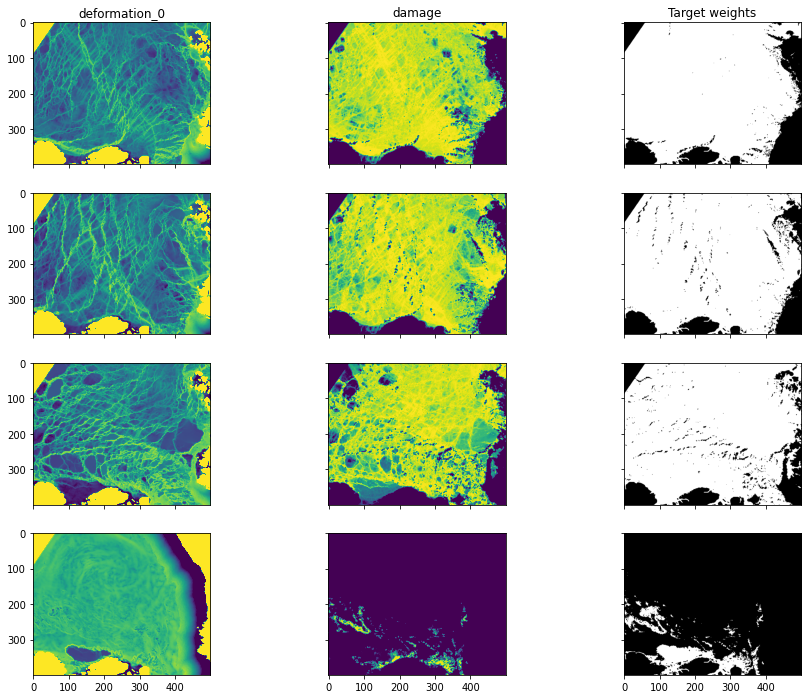

In [91]:
# Plot to check
iplot = [0, 10, 200, 528]

fig, ax = plt.subplots(nrows=len(iplot), ncols=3,sharex='all', sharey='all', figsize=(15,3*len(iplot)))

for iy in range(len(iplot)):
    ax[iy,0].imshow(X[iplot[iy],...,0],vmin=-10, vmax=-4)
    ax[iy,1].imshow(target_weighted[iplot[iy],...,0])
    ax[iy,2].imshow(target_weighted[iplot[iy],...,1],cmap='gray')
ax[0,0].set_title(colnames[0]);
ax[0,1].set_title('damage');
ax[0,2].set_title('Target weights');


In [92]:
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_loss(y_true_and_weights, y_pred):
    y_true = y_true_and_weights[...,0:1]
    weights = y_true_and_weights[...,1:]
    squared_difference = K.square(y_true - y_pred)
    weighted_squared_difference = tf.multiply(weights,squared_difference)
    return K.mean(weighted_squared_difference, axis=-1) 

In [93]:
from tensorflow.keras.layers import Conv2D, Input
from tensorflow.keras.models import Model
x_in = Input(shape=(None, None, 1))
x_out = Conv2D(1, 1, padding='same')(x_in)
dummy = Model(x_in, x_out, name='dummy')
dummy.compile(loss=custom_loss)

In [94]:
ypredict = dummy.predict(X)
ypredict.shape

(529, 400, 500, 1)

In [95]:
def test_custom_loss(dummy, XX, yy):
    """Test if the Keras model has a cost of zeros over the masked pixels
    """
    mask = yy[...,1:]==0
    weights = yy[...,1:]>0
    eval1 = dummy.evaluate(XX, yy, batch_size=20)
    yy_bis = yy.copy()
    yy_bis[...,0][mask[...,0]] = 2
    plt.imshow(yy_bis[10,...,0]-yy[10,...,0])
    plt.show()
    diff1 = np.linalg.norm(yy_bis[...,0]-yy[...,0])
    eval2 = dummy.evaluate(XX, yy_bis, batch_size=20)
    yy_bis = yy.copy()
    yy_bis[...,0][weights[...,0].astype('bool')] = 2
    plt.imshow(yy_bis[10,...,0]-yy[10,...,0])
    plt.show()
    diff2 = np.linalg.norm(yy_bis[...,0]-yy[...,0])
    eval3 = dummy.evaluate(XX, yy_bis, batch_size=20)

    assert diff1>0
    assert eval1 == eval2
    assert diff2 >2
    assert eval1 != eval3
    return 0

1/1 [==============================] - 0s 2ms/step - loss: 24.6262


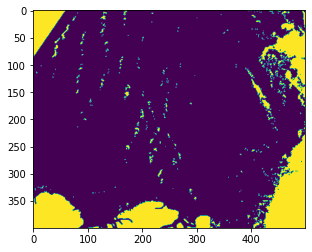

1/1 [==============================] - 0s 1ms/step - loss: 24.6262


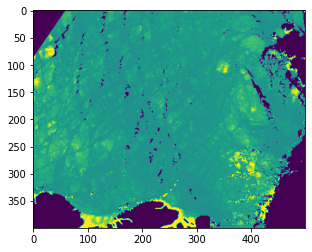

1/1 [==============================] - 0s 2ms/step - loss: 36.1716


0

In [96]:
test_custom_loss(dummy, X[:20],target_weighted[:20])


In [101]:
# Transform big images to smaller ones
X2 = X[:2]
y2 = target_weighted[:2]

def im2tile(X2,y2, dsize=25,slic=1):
    nn,ny,nx,nc = X2.shape
    print(nn,ny,nx,nc)
    nrows = (ny-dsize)//slic + 1
    ncols = (nx-dsize)//slic +1
    print(nrows,ncols)

    X1 = np.empty((nrows*ncols*nn,dsize,dsize,nc))
    y1 = np.zeros((nrows*ncols*nn,2))
    print (X1.shape)
    k=0
    for im in range(nn):
        for ix in range(ncols):
            for iy in range(nrows):
                X1[k,:,:,:] = X2[im,iy*slic:iy*slic+dsize,ix*slic:ix*slic+dsize,:]
                y1[k,:] = y2[im,iy*slic+dsize//2,ix*slic+dsize//2,:]
                k=k+1
    return X1,y1

def tile2im(X1,y1,slic=1,ny=400,nx=500):
    dsize = X1.shape[1]
    nrows = (ny-dsize)//slic + 1
    ncols = (nx-dsize)//slic +1
    nn = X1.shape[0]//(nrows*ncols)
    X2 = np.empty((nn,ny,nx,nc))
    y2 = np.zeros((nn,ny,nx,2))
    print(nn,nrows,ncols)
    k=0
    for im in range(nn):
        for ix in range(ncols):
            for iy in range(nrows):
                X2[im,iy*slic:iy*slic+dsize,ix*slic:ix*slic+dsize,:]=X1[k,:,:,:]
                y2[im,iy*slic+dsize//2,ix*slic+dsize//2,:]=y1[k,:]
                k=k+1
    return X2, y2

In [102]:
X1, y1 = im2tile(X2,y2)
X2r, y2r, = tile2im(X1,y1)


2 400 500 1
376 476
(357952, 25, 25, 1)
2 376 476


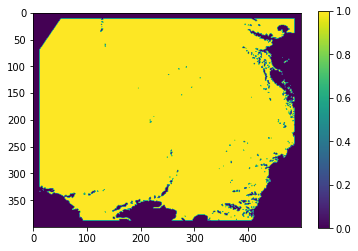

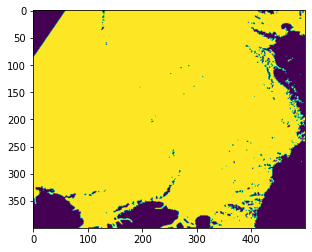

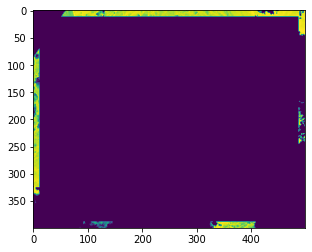

In [104]:
plt.imshow(y2r[1,...,1])
plt.colorbar()
plt.show()
plt.imshow(y2[1,...,1])
plt.show()
plt.imshow(y2[1,...,0]-y2r[1,...,0])


In [109]:
mask_train = y1[:,1]>0
print(mask_train.shape,mask_train.sum())
Xtrain = X1[mask_train,:]
ytrain = y1[mask_train,0]
print(Xtrain.shape, ytrain.shape)

(357952,) 313670
(313670, 25, 25, 1) (313670,)


In [80]:
import autokeras as ak


In [113]:
reg = ak.ImageRegressor(
    overwrite = True, #start from scratch
    max_trials=1)


In [114]:
reg.fit(
    Xtrain,
    ytrain,
    validation_split=0.15,
    epochs=2,
)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
image_block_4/n...|False             |?                 
image_block_4/a...|False             |?                 
image_block_4/b...|resnet            |?                 
image_block_4/r...|False             |?                 
image_block_4/r...|resnet50          |?                 
image_block_4/r...|False             |?                 
regression_head...|0.5               |?                 
optimizer         |adam  

KeyboardInterrupt: 

(0.9, 1.0)

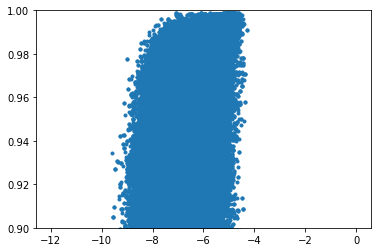

In [118]:
plt.plot(Xtrain[:,12,12,:].ravel(),ytrain.ravel(),'.')
plt.ylim((0.9,1))